In [ ]:
import numpy as np
from scipy.fftpack import dct, idct
from PIL import Image
import matplotlib.pyplot as plt
import heapq
import pickle

JPEG ENCODER

In [ ]:
class JPEGencoder:
    def __init__(self):
        self.quantization_matrix = np.array([
              [16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]
        ])

    def pre_process(self,image_path):
        image = Image.open(image_path)  # This is assumed to be grayscale already
        # Preprocessing: Shift pixel values to range [-128, 127]
        image_np = np.array(image, dtype=np.float32) - 128

        # Ensure the image size is a multiple of 8 (JPEG block size requirement)
        image_np = image_np[:image_np.shape[0] // 8 * 8, :image_np.shape[1] // 8 * 8]

        return image_np

    def blockify(self,image, block_size=8):
        """Divide image into non-overlapping blocks."""
        h, w = image.shape
        return (image.reshape(h // block_size, block_size, -1, block_size)
                    .swapaxes(1, 2)
                    .reshape(-1, block_size, block_size))

    def apply_dct(self,block):
      """Apply 2D Discrete Cosine Transform."""
      return dct(dct(block.T, norm='ortho').T, norm='ortho')

    def build_huffman_tree(self,data):
        """Build a Huffman tree for the data."""
        frequency = {}
        for value in data:
            value = tuple(value) if isinstance(value, tuple) else (value,)  # Wrap single values in tuples
            frequency[value] = frequency.get(value, 0) + 1

        heap = [[freq, [symbol, ""]] for symbol, freq in frequency.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            low = heapq.heappop(heap)
            high = heapq.heappop(heap)
            for pair in low[1:]:
                pair[1] = '0' + pair[1]
            for pair in high[1:]:
                pair[1] = '1' + pair[1]
            heapq.heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])

        return {tuple(symbol): code for symbol, code in heapq.heappop(heap)[1:]}


    def huffman_encode(self,data, huffman_tree):
        """Encode data using Huffman coding."""
        encoded_data = []
        for symbol in data:
            # Ensure symbol is always treated as a tuple
            if isinstance(symbol, tuple):
                key = tuple(symbol)  # Ensure it's hashable
            else:
                key = (symbol,)  # Wrap non-tuples in a tuple
            if key in huffman_tree:
                encoded_data.append(huffman_tree[key])
            else:
                raise KeyError(f"Symbol {key} not found in Huffman tree.")
        return ''.join(encoded_data)

    def zigzag_traversal(self,matrix):
        # Get the size of the matrix
        n = matrix.shape[0]  # Assuming the matrix is square (n x n)

        # Initialize parameters
        array = np.zeros(n * n)  # Result array to hold elements in zigzag order
        array_index = 0  # Index for storing elements in result array

        # Zigzag traversal across diagonals
        for sum_idx in range(1, 2 * n):  # sum_idx goes from 1 to 2*n - 1
            if sum_idx % 2 == 0:
                # Traverse top-left to bottom-right on even diagonals
                for i in range(max(0, sum_idx - n), min(n, sum_idx)):
                    j = sum_idx - i - 1
                    array[array_index] = matrix[i, j]
                    array_index += 1
            else:
                # Traverse bottom-right to top-left on odd diagonals
                for j in range(max(0, sum_idx - n), min(n, sum_idx)):
                    i = sum_idx - j - 1
                    array[array_index] = matrix[i, j]
                    array_index += 1

        return array
    def run_length_encode(self,array, huffman_tree):
        """
        Perform run-length encoding as per the JPEG compression requirements.
        - Each non-zero coefficient is represented as a triple:
            (run-length, size, Huffman code for the coefficient)
        - Handles special cases:
            * (15, 0, 0) for 16 zeros in a row
            * End-of-Block (EOB) marker: (0, 0)
        """
        result = []
        zeros_count = 0

        for value in array:
            if value == 0:
                zeros_count += 1
                # Insert (15, 0, 0) for every 16 zeros
                if zeros_count == 16:
                    result.append((15, 0, 0))
                    zeros_count = 0
            else:
                # Encode the non-zero coefficient after zeros
                huffman_code = self.huffman_encode([value], huffman_tree)  # Use huffman_encode
                size = len(huffman_code)
                if zeros_count > 0:
                    result.append((zeros_count, size, huffman_code))
                    zeros_count = 0
                else:
                    result.append((0, size, huffman_code))

        # Append End-of-Block (EOB) marker if trailing zeros exist
        if zeros_count > 0:
            result.append((0, 0))
        return result

    def jpeg_compress(self,image_path, quality ):
        """Compress the image using JPEG-like steps with DC coefficient difference."""
        image = self.pre_process(image_path)
        blocks = self.blockify(image)
        quant_matrix = self.quantization_matrix*50/quality
        # print(blocks.shape)
        dc_values = []
        ac_values = []
        quantized_blocks=[]
        prev_dc = 0  # Initialize previous DC coefficient

        for block in blocks:
            dct_block = self.apply_dct(block)
            quantized_block = np.round(dct_block / quant_matrix).astype(int)
            quantized_blocks.append(quantized_block)
            # Compute the DC coefficient as the difference from the previous block's DC
            dc_value = quantized_block[0, 0]
            dc_diff = dc_value - prev_dc
            dc_values.append(dc_diff)  # Store the difference

            prev_dc = dc_value  # Update previous DC coefficient

            # Get the AC coefficients (zigzag the quantized block)
            ac_coefficients = self.zigzag_traversal(quantized_block)[1:]
            ac_values.extend(ac_coefficients)


        # Build Huffman tree for DC and AC separately
        huffman_tree_dc = self.build_huffman_tree(dc_values)
        huffman_tree_ac = self.build_huffman_tree(ac_values)
        # print("these are before dc values", dc_values)
        # print(huffman_tree_dc)
        # print("ac_tree",huffman_tree_ac)
        # print("ac_values",ac_values)

        # Huffman encoding for DC and AC values
        huffman_encoded_dc = self.huffman_encode(dc_values, huffman_tree_dc)
        # print(huffman_encoded_dc,"this is encoded dc")
        # huffman_encoded_ac = huffman_encode(ac_values, huffman_tree_ac)

        # Run-length encoding for AC coefficients
        rle_ac_encoded = self.run_length_encode(ac_values,huffman_tree_ac)
        # print(rle_ac_encoded,"this is before rle encoded ac values")

        # print(huffman_encoded_dc)
        # print(rle_ac_encoded)

        return huffman_encoded_dc, rle_ac_encoded , huffman_tree_dc, huffman_tree_ac

    def save_compressed_file(self,filename, image, quality):

        huffman_encoded_dc, rle_ac_encoded, huffman_tree_dc, huffman_tree_ac = self.jpeg_compress(image_path, quality)
        image_shape = image.shape
        color_mode = 'grayscale' if len(image.shape) == 2 else 'color'

        quant_matrix = self.quantization_matrix*50/quality
        with open(filename, 'wb') as f:
            pickle.dump({
                'huffman_encoded_dc': huffman_encoded_dc,
                'rle_ac_encoded': rle_ac_encoded,
                'huffman_tree_dc': huffman_tree_dc,
                'huffman_tree_ac': huffman_tree_ac,
                'image_shape': image_shape,
                'quant_matrix': quant_matrix,
                'color_mode': color_mode
            }, f)



JPEG DECODER

In [ ]:
class JPEGdecoder:
    def unblockify(self,blocks, image_shape):
      """Reconstruct the image from 8x8 blocks."""
      h, w = image_shape
      blocks_per_row = w // 8
      image = np.zeros(image_shape, dtype=np.float32)
      for i, block in enumerate(blocks):
          row = (i // blocks_per_row) * 8
          col = (i % blocks_per_row) * 8
          image[row:row + 8, col:col + 8] = block
      return image


    def apply_idct(self, block):
        """Apply Inverse DCT to an 8x8 block."""
        return idct(idct(block.T, norm='ortho').T, norm='ortho')

    def zigzag_reconstruct(self, array, n):
        """
        Reconstruct the matrix from a zigzag traversal array.

        Parameters:
        - array: The array obtained from zigzag traversal
        - n: Size of the original matrix (n x n)

        Returns:
        - matrix: The reconstructed n x n matrix
        """
        # Initialize the matrix
        array = np.array(array)
        matrix = np.zeros((n, n), dtype=array.dtype)  # Create an empty matrix

        # Initialize array index for traversing the input array
        array_index = 0

        # Reconstruct the matrix following the zigzag pattern across diagonals
        for sum_idx in range(1, 2 * n):  # sum_idx goes from 1 to 2*n - 1
            if sum_idx % 2 == 0:
                # Traverse top-left to bottom-right on even diagonals
                for i in range(max(0, sum_idx - n), min(n, sum_idx)):
                    j = sum_idx - i - 1
                    matrix[i, j] = array[array_index]
                    array_index += 1
            else:
                # Traverse bottom-right to top-left on odd diagonals
                for j in range(max(0, sum_idx - n), min(n, sum_idx)):
                    i = sum_idx - j - 1
                    matrix[i, j] = array[array_index]
                    array_index += 1

        return matrix
    def reconstruct_blocks(self, dc_values_reconstructed, ac_values):
        """
        Reconstruct 8x8 blocks from DC and AC coefficients.
        """
        blocks = []
        ac_index = 0

        for dc_value in dc_values_reconstructed:
            # Start with an empty block
            block = np.zeros((8, 8), dtype=int)
            block[0, 0] = dc_value  # DC coefficient

            # Insert AC coefficients using zigzag order
            if ac_index + 63 <= len(ac_values):  # Ensure no overflow
                ac_coeffs = ac_values[ac_index:ac_index + 63]
                # Combine DC and AC coefficients
                zigzag_array = [dc_value] + ac_coeffs
                block = self.zigzag_reconstruct(zigzag_array,8)
                ac_index += 63
            else:
                break

            blocks.append(block)

        return blocks


    def huffman_decode(self,encoded_data, huffman_tree):
        """Decode Huffman-encoded data."""
        reverse_tree = {v: k for k, v in huffman_tree.items()}
        current_code = ""
        decoded = []
        for bit in encoded_data:
            current_code += bit
            if current_code in reverse_tree:
                decoded_symbol = reverse_tree[current_code]
                decoded.append(decoded_symbol if len(decoded_symbol) > 1 else decoded_symbol[0])
                current_code = ""
        return decoded



    def run_length_decode(self,rle_encoded, huffman_tree):
        """
        Decode run-length encoded AC coefficients back into their original zigzag order.
        Handles:
        - (run-length, size, Huffman code for the coefficient)
        - Special cases:
            * (15, 0, 0) for 16 zeros in a row
            * End-of-Block (EOB) marker: (0, 0)
        """
        decoded_array = []

        for entry in rle_encoded:
            if entry == (0, 0):  # End-of-Block (EOB) marker
                break  # Stop processing, pad remaining coefficients with zeros

            # Validate the entry format
            if len(entry) != 3:
                raise ValueError(f"Invalid RLE entry format: {entry}")

            run_length, size, huffman_code = entry

            # Handle special case for 16 zeros in a row
            if (run_length, size, huffman_code) == (15, 0, 0):
                decoded_array.extend([0] * 16)
            else:
                # Insert zeros for the run length
                decoded_array.extend([0] * run_length)

                # Decode the actual coefficient from the Huffman code
                coefficient = self.huffman_decode(huffman_code, huffman_tree)[0]
                decoded_array.append(coefficient)

        return decoded_array


    def load_compressed_file(self, filename):
        """Load compressed data from a file."""
        with open(filename, 'rb') as f:
            compressed_data = pickle.load(f)
        return compressed_data

    def jpeg_decompress_with_huffman(self,filename):
        """Decompress JPEG-like compressed file with DC coefficient difference."""

        # Load compressed data
        data = self.load_compressed_file(filename)
        huffman_encoded_dc = data['huffman_encoded_dc']
        rle_ac_encoded = data['rle_ac_encoded']
        huffman_tree_dc = data['huffman_tree_dc']
        huffman_tree_ac = data['huffman_tree_ac']
        image_shape = data['image_shape']
        quant_matrix = data['quant_matrix']
        color_mode = data['color_mode']

        # Decode DC coefficients (Huffman decoding)
        dc_values = self.huffman_decode(huffman_encoded_dc, huffman_tree_dc)
        # rle_ac_encoded = self.huffman_decode(rle_ac_encoded, huffman_tree_ac)
        # print("these are after dc values" , dc_values)

        # Run-length decode AC coefficients
        ac_values = self.run_length_decode(rle_ac_encoded, huffman_tree_ac)
        # print("these are after ac values" , rle_ac_encoded)

        # Reconstruct the DC coefficients (add the previous DC to get the current DC)
        dc_values_reconstructed = []
        prev_dc = 0
        for dc_diff in dc_values:
            dc_value = dc_diff + prev_dc
            dc_values_reconstructed.append(dc_value)
            prev_dc = dc_value


        blocks=self.reconstruct_blocks(dc_values_reconstructed, ac_values)

        # Dequantization and IDCT
        dequantized_blocks = [block * quant_matrix for block in blocks]
        # print(len(dequantized_blocks[0]))
        idct_blocks = [self.apply_idct(block) for block in dequantized_blocks]

        # print(idct_blocks[0])


        # Reassemble the blocks into the full image
        reconstructed_image = self.unblockify(idct_blocks, image_shape)

        # Postprocessing: Add 128 to shift pixel values back to [0, 255]
        reconstructed_image += 128

        # Clip pixel values to valid range
        return np.clip(reconstructed_image, 0, 255).astype(np.uint8)



Visualization for JPEG

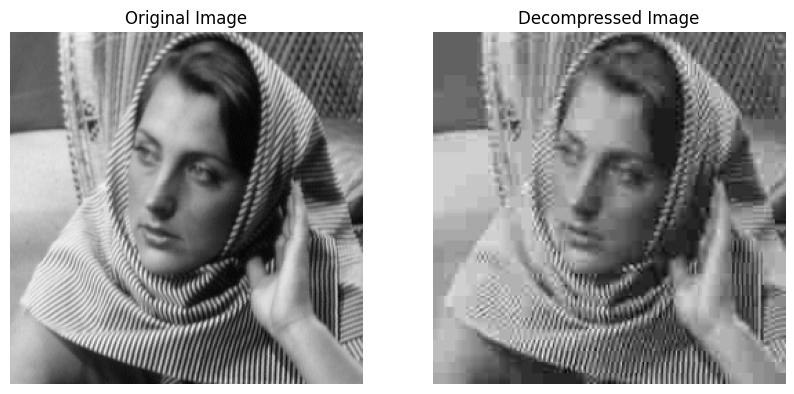

In [ ]:
image_path = '/content/barbara256.png'
encoder = JPEGencoder()
decoder = JPEGdecoder()

omg = encoder.pre_process(image_path)
encoder.save_compressed_file('compressed_image.bin', omg, quality=10)
cmg = decoder.jpeg_decompress_with_huffman('compressed_image.bin')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(omg, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Decompressed Image")
plt.imshow(cmg, cmap='gray')
plt.axis('off')
plt.show()

# **RMSE vs BPP**

In [ ]:
import os
from sklearn.datasets import fetch_olivetti_faces
import cv2
# Load a dataset (Olivetti Faces dataset as an example)
data = fetch_olivetti_faces()
images = data.images
images = (images*255).astype(np.uint8)
images = np.array([cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA) for img in images])

n_samples, height, width = images.shape
print(f"Dataset loaded with {n_samples} images of size {height}x{width}.")


Dataset loaded with 400 images of size 256x256.


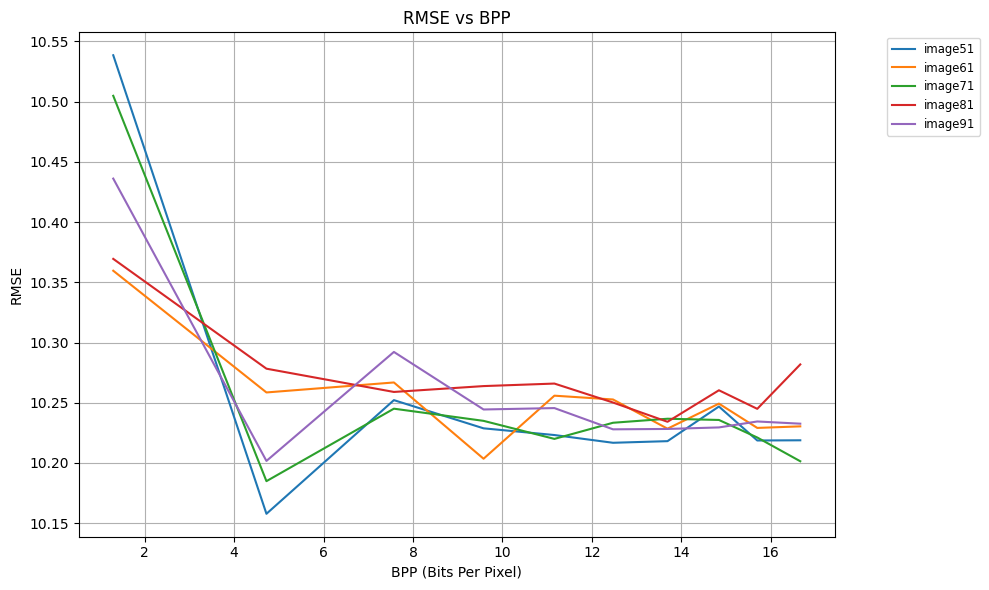

In [ ]:
def calculate_rmse(original, compressed):
    return np.sqrt(np.mean((original - compressed) ** 2))

def calculate_bpp(compressed_file, original_img):
    file_size = os.path.getsize(compressed_file)
    compressed_size = file_size * 8  # Convert bytes to bits
    num_pixels = original_img.shape[0] * original_img.shape[1]
    return compressed_size / num_pixels

encoder = JPEGencoder()
decoder = JPEGdecoder()

# image_path = '/content/barbara256.png'
# image = Image.open(image_path)
# omg = np.array(image, dtype=np.float32)

quality_factors = range(1,101,10)
plt.figure(figsize = (10,6))

for i in range (51,101,10):
  rmse_values = []
  bpp_values = []
  omg = images[i]
  for q in quality_factors:
    encoder.save_compressed_file(f'compressed_img_q#{q}.bin', omg, q)
    cmg = decoder.jpeg_decompress_with_huffman(f"compressed_img_q#{q}.bin")
    rmse = calculate_rmse(omg, cmg)
    bpp = calculate_bpp(f'compressed_img_q#{q}.bin', omg)
    rmse_values.append(rmse)
    bpp_values.append(bpp)
    os.remove(f'compressed_img_q#{q}.bin')
  # plt.plot(bpp_O_values, rmse_O_values, label = 'orig jpeg')
  plt.plot(bpp_values, rmse_values, label= f'image{i}')
  plt.xlabel("BPP (Bits Per Pixel)")
  plt.ylabel("RMSE")
  plt.title("RMSE vs BPP")
  plt.legend(loc="upper right", fontsize='small', bbox_to_anchor=(1.2, 1))
  plt.grid(True)
  plt.tight_layout()
plt.show()



# **Comparison with existing implementation of JPEG**

In [ ]:
from PIL import Image
import os

def jpeg_compression(input_image_path, output_image_path, quality):
    """
    Compresses an image using JPEG compression, saves the compressed file,
    and returns the compressed file size.
    """
    original_image = Image.open(input_image_path)
    original_image = original_image.convert("L")
    # JPEG compression
    original_image.save(output_image_path, format="JPEG", quality=quality)

    # size of the compressed file
    compressed_file_size = os.path.getsize(output_image_path)

    return compressed_file_size

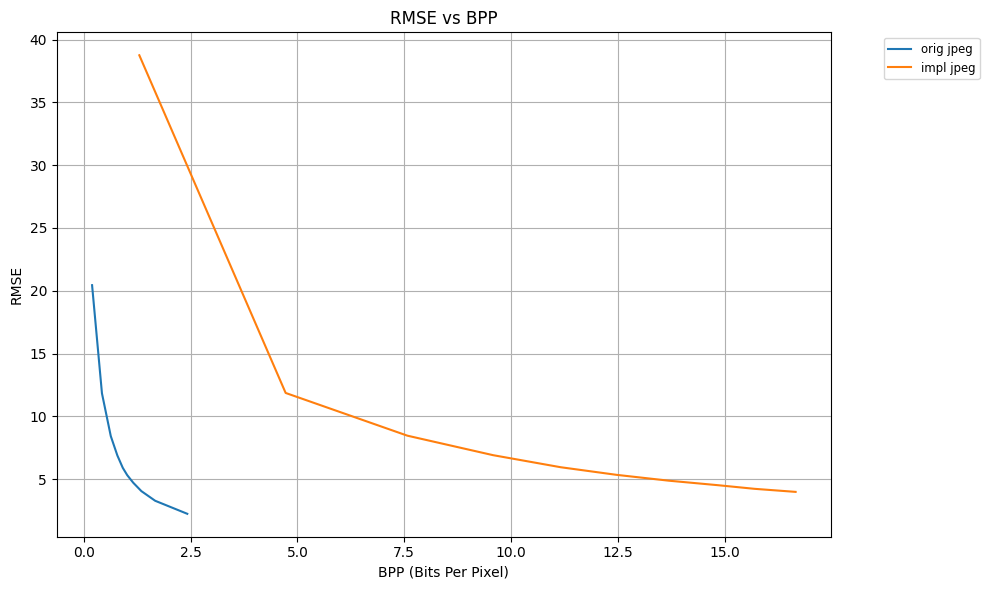

In [ ]:
# Compression using existing JPEG
image_path = '/content/barbara256.png'
oimg = Image.open(image_path)
oimg = np.array(oimg, dtype=np.float32)

rmse_O_values = []
bpp_O_values = []
quality_factors = range(1,101,10)
for q in quality_factors:

  jpeg_compression(image_path,f"c_img_q#{q}.bin",q)
  cimg = Image.open(f"c_img_q#{q}.bin")
  cimg = np.array(cimg, dtype=np.float32)
  rmse = calculate_rmse(oimg, cimg)
  bpp = calculate_bpp(f'c_img_q#{q}.bin', oimg)
  rmse_O_values.append(rmse)
  bpp_O_values.append(bpp)


# Compression using implemented JPEG
encoder = JPEGencoder()
decoder = JPEGdecoder()

quality_factors = range(1,101,10)
plt.figure(figsize = (10,6))

rmse_values = []
bpp_values = []

for q in quality_factors:
  encoder.save_compressed_file(f'compressed_img_q#{q}.bin', oimg, q)
  cmg = decoder.jpeg_decompress_with_huffman(f"compressed_img_q#{q}.bin")
  rmse = calculate_rmse(oimg, cmg)
  bpp = calculate_bpp(f'compressed_img_q#{q}.bin', oimg)
  rmse_values.append(rmse)
  bpp_values.append(bpp)

plt.plot(bpp_O_values, rmse_O_values, label = 'orig jpeg')
plt.plot(bpp_values, rmse_values, label= 'impl jpeg')
plt.xlabel("BPP (Bits Per Pixel)")
plt.ylabel("RMSE")
plt.title("RMSE vs BPP")
plt.legend(loc="upper right", fontsize='small', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()



# **PCA based Image Compression**

Image Preprocessing

In [ ]:
 import os
from sklearn.datasets import fetch_olivetti_faces
import cv2
# Load a dataset (Olivetti Faces dataset as an example)
data = fetch_olivetti_faces()
images = data.images
n_samples, height, width = images.shape

print(f"Dataset loaded with {n_samples} images of size {height}x{width}.")


Dataset loaded with 400 images of size 64x64.


PCA based Image Compression

In [ ]:
from sklearn.decomposition import PCA

def pca_img_compression(images, variance_threshold):
    pca = PCA()
    n_samples, height, width = images.shape
    flatten_images = images.reshape(n_samples, height*width)
    pca.fit(flatten_images)

    # cumulative variance explained
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # no. of components for desired varaince
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Perform PCA with the selected number of components
    pca = PCA(n_components=n_components)
    compressed = pca.fit_transform(flatten_images)
    reconstructed_imgs = pca.inverse_transform(compressed)

    return reconstructed_imgs, pca, n_components

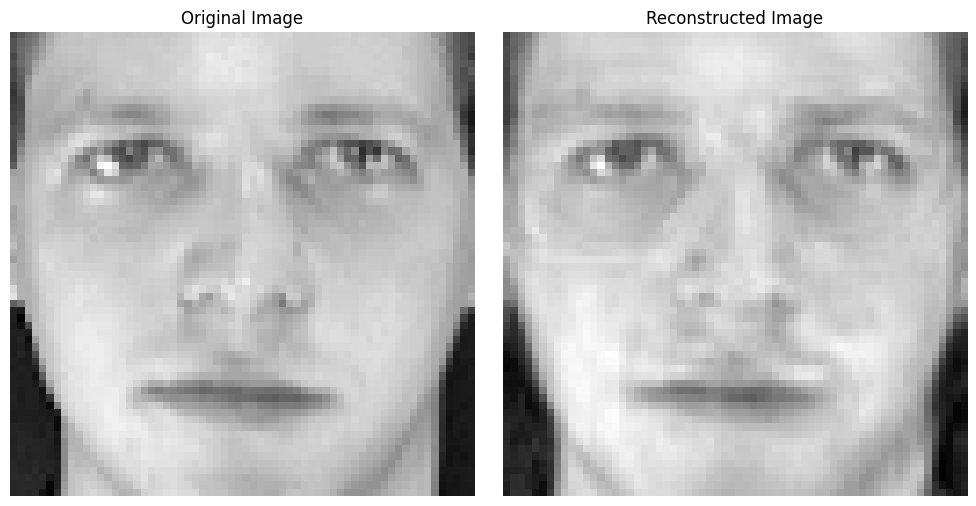

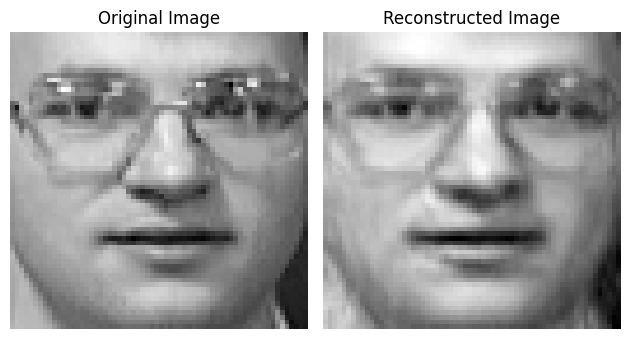

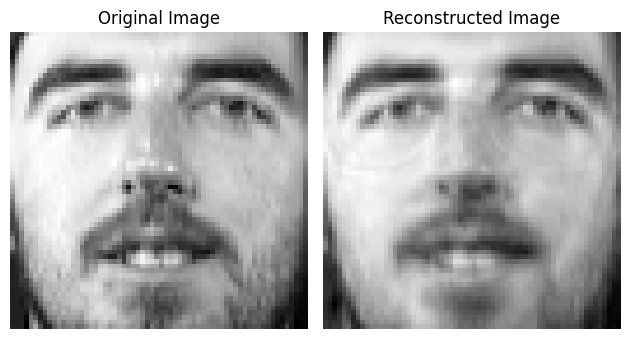

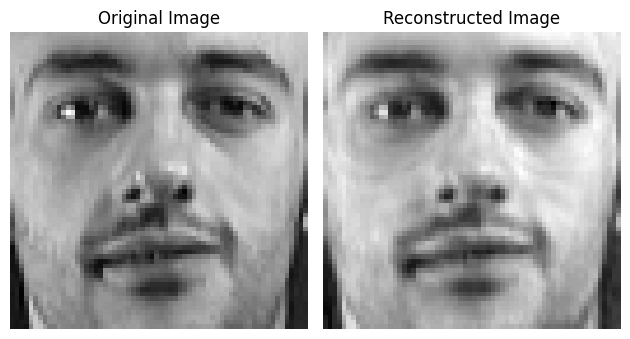

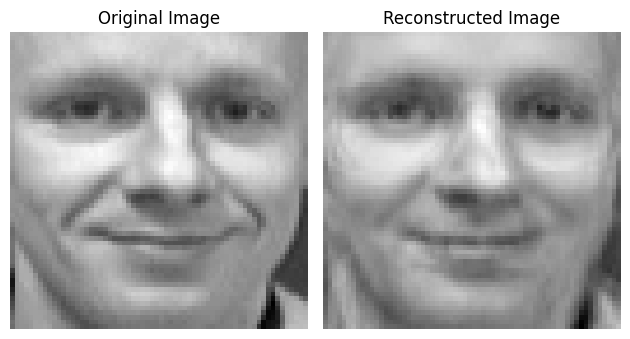

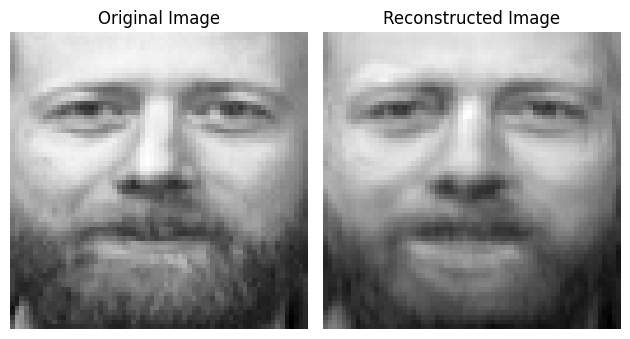

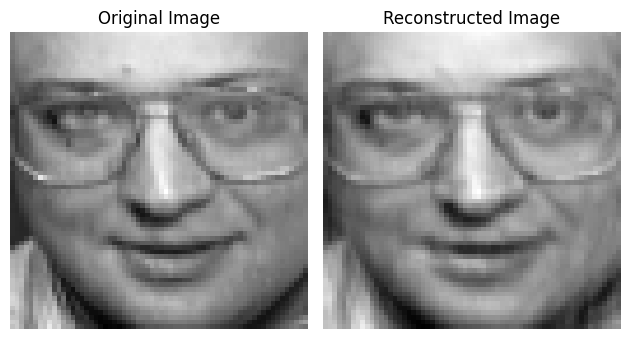

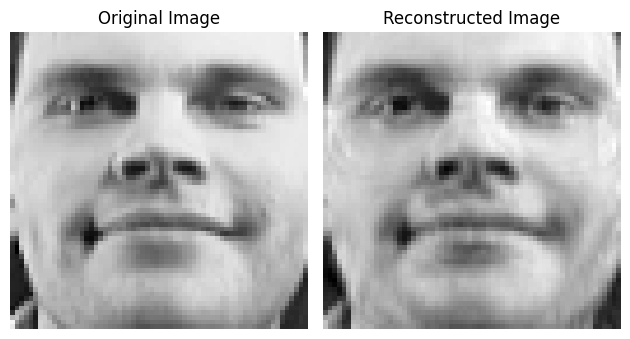

In [ ]:
desired_variance = 0.95  # Retain 95% of the variance
reconstructed_imgs, pca, n_components = pca_img_compression(images, desired_variance)
reconstructed_imgs = reconstructed_imgs.reshape(n_samples,64,64)

# visualizing some imgs
plt.figure(figsize=(10, 5))
for i in range(0,400,50):
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_imgs[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
n_components

123

PLot of Compression ratios vs No. of Components

In [ ]:
def calc_compr_ratio(image_dataset, n_components):

  n_samples, height, width = images.shape
  d = height*width
  N = n_samples
  k = n_components
  orginal_size = d*N*8
  compressed_size = 32*N*k +32*d*k + 8*d
  compressionratio = orginal_size/compressed_size
  return compressionratio

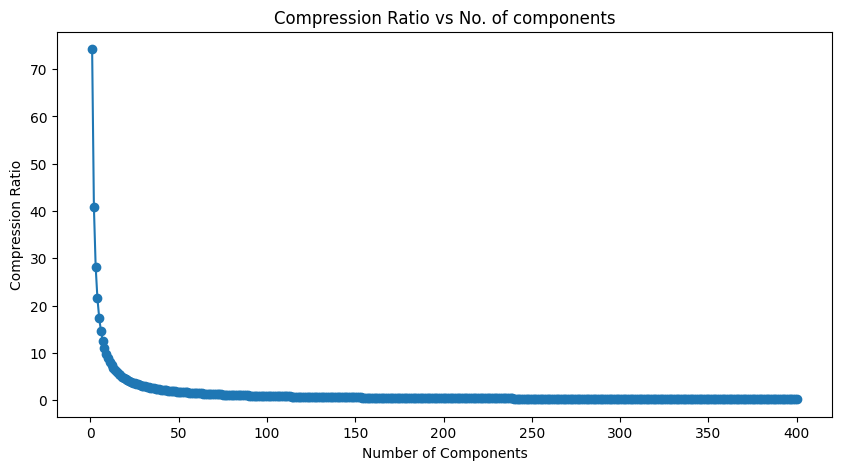

In [ ]:
# plot of compression ratio vs no. of components
n_components = range(1,images.shape[0]+1)
compression_ratios = []
for i in n_components:
  compres_ratio = calc_compr_ratio(images, i)
  compression_ratios.append(compres_ratio)

plt.figure(figsize=(10, 5))
plt.plot(n_components, compression_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs No. of components')
plt.show()

# plot of no.of components vs desired threshold

# plot of RMSE per image for varied desried threshold


PLot of RMSE vs Variance Retained

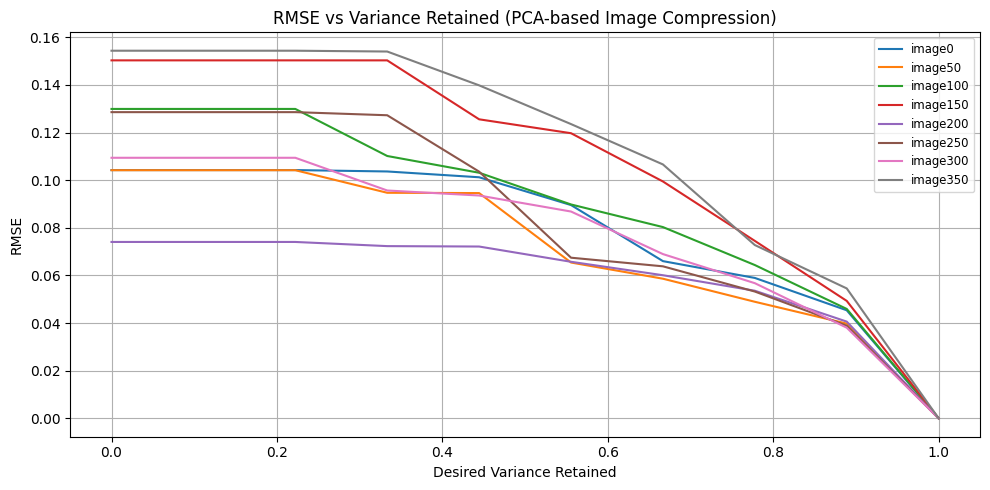

In [ ]:
desired_variance  = np.linspace(0,1,10)

rmse_values = {i: [] for i in range (0,400,50)}
for var in desired_variance:
  reconstructed_imgs, pca, n_components = pca_img_compression(images, var)
  reconstructed_imgs = reconstructed_imgs.reshape(n_samples,64,64)

  for i in range (0,400,50):
    rmse = calculate_rmse(images[i], reconstructed_imgs[i])
    rmse_values[i].append(rmse)

plt.figure(figsize=(10, 5))
for i in range(0,400,50):
  plt.plot(desired_variance, rmse_values[i], label= f'image{i}')

plt.xlabel("Desired Variance Retained")
plt.ylabel("RMSE")
plt.title("RMSE vs Variance Retained (PCA-based Image Compression)")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

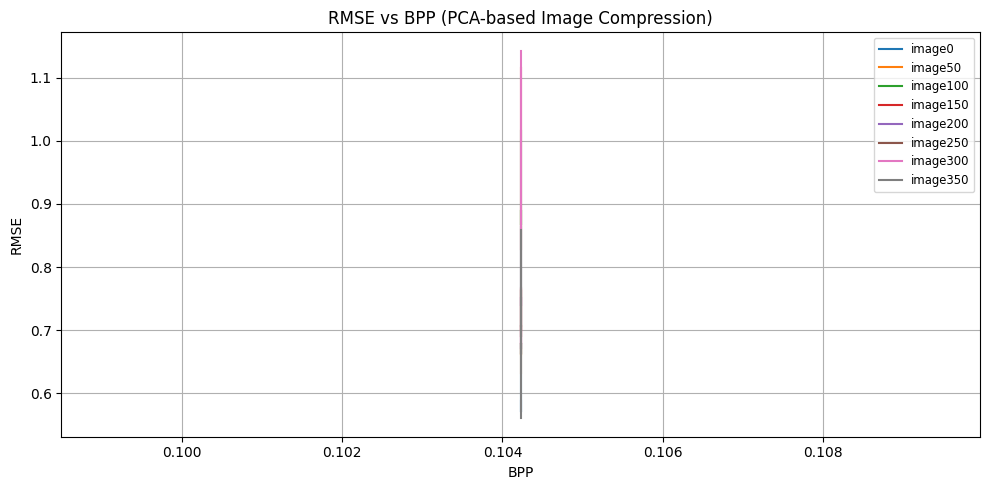

In [ ]:
desired_variance  = np.linspace(0,1,10)

rmse_pca_values = {i: [] for i in range (0,400,50)}
bpp_pca_values = {i: [] for i in range(0,400,50)}

save_dir = 'reconstructed_images/'
os.makedirs(save_dir, exist_ok = True)

for var in desired_variance:
  reconstructed_imgs, pca, n_components = pca_img_compression(images, var)
  reconstructed_imgs = reconstructed_imgs.reshape(n_samples,64,64)

  for i in range (0,400,50):
    image_filename = os.path.join(save_dir, f"reconstructed_img_{i}.png")
    cv2.imwrite(image_filename, reconstructed_imgs[i])
    bpp = calculate_bpp(image_filename, images[i])
    rmse_pca_values[i].append(rmse)
    bpp_pca_values[i].append(bpp)
    os.remove(image_filename)

plt.figure(figsize=(10, 5))
for i in range(0,400,50):
  plt.plot(rmse_pca_values[i], bpp_pca_values[i], label= f'image{i}')

plt.xlabel("BPP")
plt.ylabel("RMSE")
plt.title("RMSE vs BPP (PCA-based Image Compression)")
plt.legend(loc="upper right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()